In [21]:
'''
@Author: Stefan Angelov
@Created: 04/23/2021
@Purpose: Predicting the air pollution
'''

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import math
from math import sqrt
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()
pd.options.display.max_columns = 100


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator




# Part I Quick EDA

In [2]:
path = '../data/PRSA_Data_Aotizhongxin_20130301-20170228.csv'

def parse(x):
    return datetime.datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv(path, parse_dates = [['year', 'month', 'day', 'hour']],index_col=0, date_parser=parse)
dataset.columns = ['No','PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']
dataset.index = pd.to_datetime(dataset.index)

print(f'shape: {dataset.shape}')
dataset.head(5)

shape: (35064, 14)


,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day_hour,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,2,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,3,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,4,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,5,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


Text(0.5, 1.0, 'Count of Logins by Day')

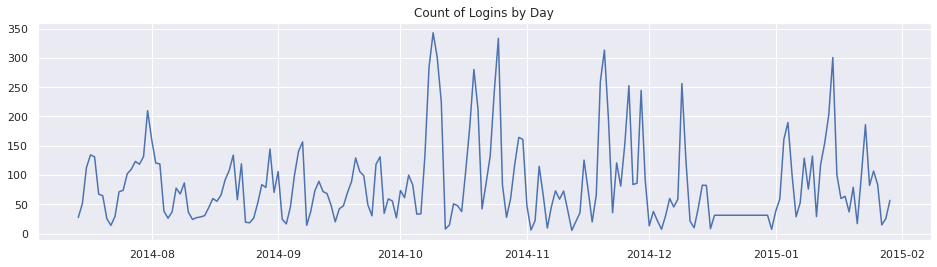

In [49]:
# plot the avg daily PM2.5
data_daily = dataset['PM2.5'].resample('D').mean()
data_daily.columns = 'PM2.5'
data_daily = data_daily.ffill()
logins_daily = data_daily[500:700]
# seasonal patter, cyclical, maybe a lot of fire at this part of the year
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(logins_daily)
ax.set_title("Count of Logins by Day")

Text(0.5, 1.0, 'Count of Logins by Month')

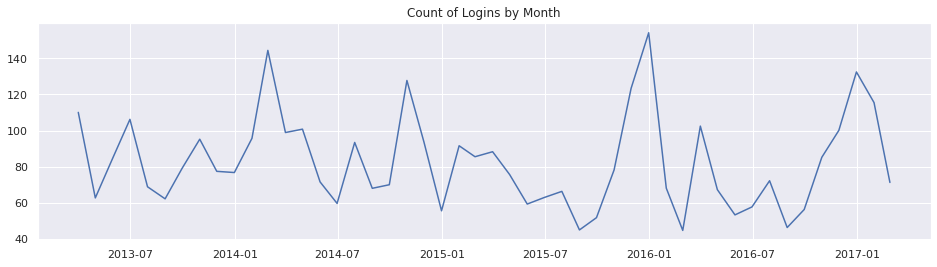

In [50]:
# plot the avg by month PM2.5
data_monthly = dataset['PM2.5'].resample('M').mean()
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_monthly)
ax.set_title("Count of Logins by Month")

Text(0.5, 1.0, 'Count of Logins by Year')

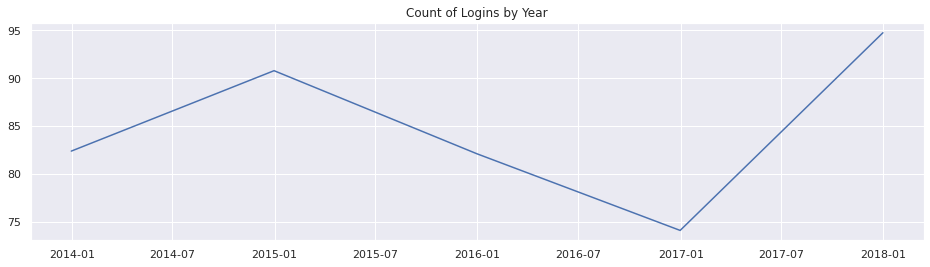

In [51]:
# plot the avg by month PM2.5
data_yearly = dataset['PM2.5'].resample('Y').mean()
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_yearly)
ax.set_title("Count of Logins by Year")

Text(0.5, 1.0, 'Count of Logins by 3 Days')

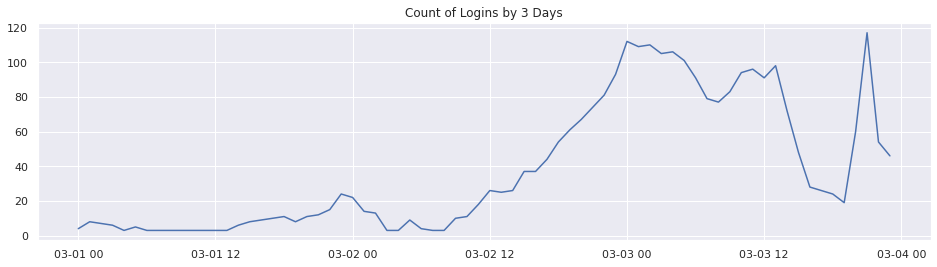

In [52]:
data_hourly_3_days = dataset['PM2.5'][:72]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly_3_days)
ax.set_title("Count of Logins by 3 Days")

Text(0.5, 1.0, 'Count of Logins by 4 Days')

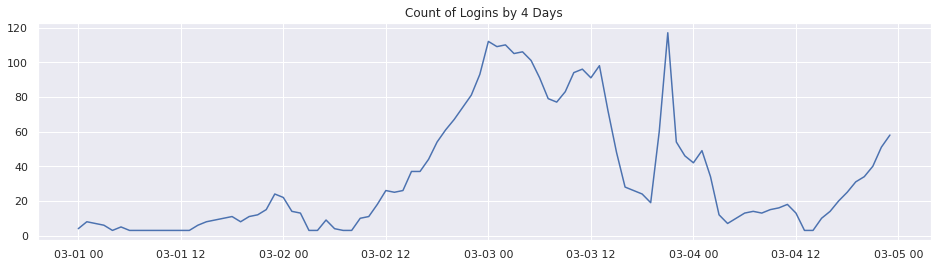

In [54]:
# plot the avg by month PM2.5
data_hourly_first_4_days = dataset['PM2.5'][:96]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly_first_4_days)
ax.set_title("Count of Logins by 4 Days")

Text(0.5, 1.0, 'Count of Logins by 4 Days')

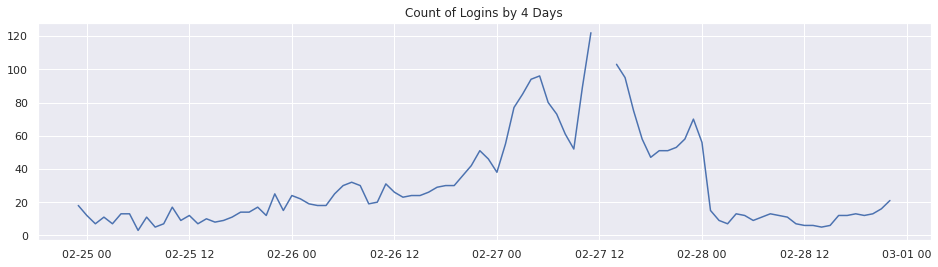

In [55]:
data_hourly_last_4_days = dataset['PM2.5'][-97:-1]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly_last_4_days)
ax.set_title("Count of Logins by 4 Days")

Text(0.5, 1.0, 'Count of Logins by Hour')

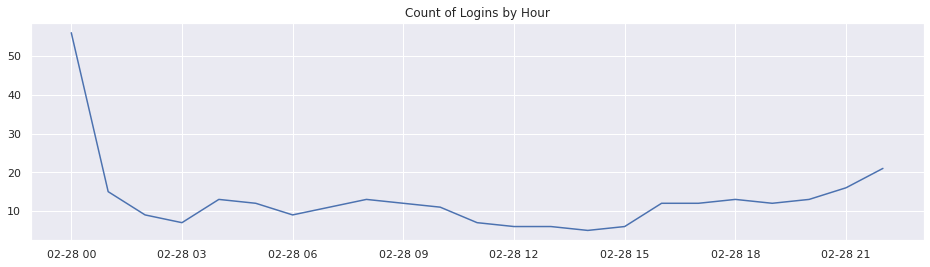

In [56]:
data_hourly = dataset['PM2.5'].resample('H').mean()
data_hourly = data_hourly[-24:-1]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly)
ax.set_title("Count of Logins by Hour")

I want to see if I can pick out any immediate trends. Zoom in on different time scales and do some exploration to see what you can figure out.
It looks like there could be some structured behaviour in the weeks themselves, i.e. some signal from the day of week. Let's view a few different weeks.

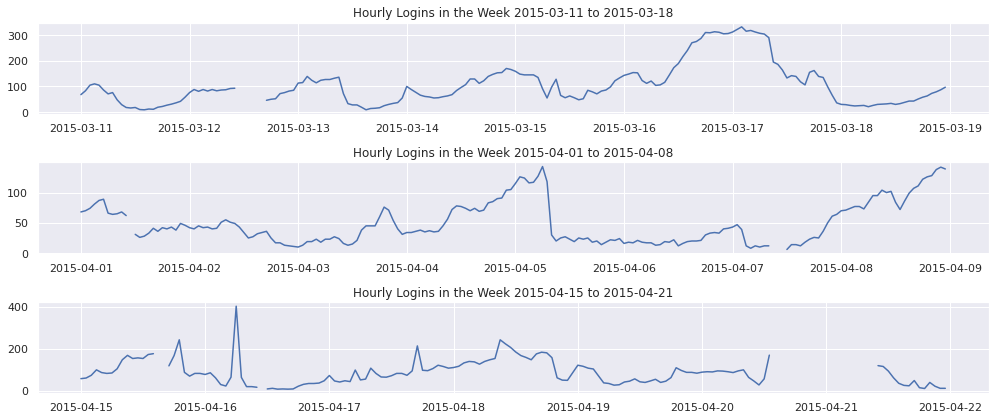

In [57]:
fig, axs = plt.subplots(3, figsize=(14, 6))
logins_hourly = dataset[['PM2.5']]
begin_dates = ['2015-03-11', '2015-04-01', '2015-04-15']
end_dates = ['2015-03-18', '2015-04-08', '2015-04-21']

for ax, begin_date, end_date in zip(axs, begin_dates, end_dates):
    logins_week = logins_hourly.loc[begin_date:end_date]
    ax.plot(logins_week)
    ax.set_title("Hourly Logins in the Week {} to {}".format(
        begin_date, end_date))
    
fig.tight_layout()

In [58]:
logins_df = pd.DataFrame(index=logins_daily.index)
logins_df['count'] = logins_daily
logins_df['day_of_week'] = logins_daily.index.weekday
logins_df.head()

,count,day_of_week
year_month_day_hour,,
2014-07-14,27.666667,0
2014-07-15,51.083333,1
2014-07-16,112.750000,2
2014-07-17,134.541667,3
2014-07-18,131.045455,4


In [59]:
is_weekend = (logins_df['day_of_week'] == 5) + (logins_df['day_of_week'] == 6)
logins_df.head()

,count,day_of_week
year_month_day_hour,,
2014-07-14,27.666667,0
2014-07-15,51.083333,1
2014-07-16,112.750000,2
2014-07-17,134.541667,3
2014-07-18,131.045455,4


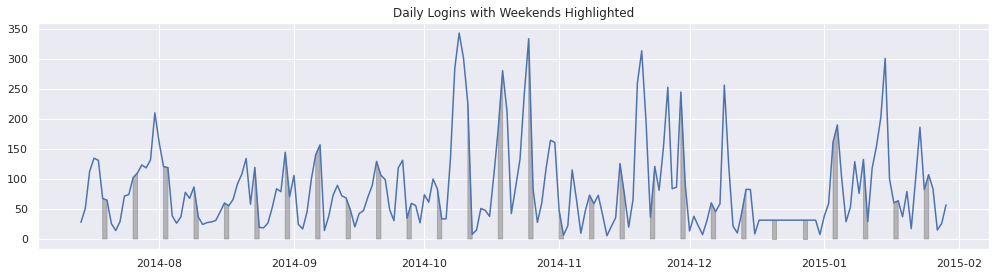

In [60]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(logins_df.index.values, logins_df['count'])

ax.fill_between(logins_df.index, 0, logins_df['count'], 
                where=is_weekend, color='grey', alpha=0.5)
ax.set_title("Daily Logins with Weekends Highlighted")

fig.tight_layout()

### Check for stationarity

In [62]:
# Split data
nobs = 4
df_train, df_test = data_daily[0:-nobs], data_daily[-nobs:]

# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
# results = adfuller(data_daily['data_daily_diff'][1:].values)
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train)
# rejecting the null p_value 0.00, it's stationary, there is no unit root

Test Statistic         -1.746269e+01
p-value                 4.588037e-30
# Lags                  2.000000e+00
# Observations          1.454000e+03
Critical Value (1%)    -3.434855e+00
Critical Value (5%)    -2.863530e+00
Critical Value (10%)   -2.567829e+00
dtype: float64
 Series is Stationary


# Part II More Complex EDA
### Read Data
##### Read all CSV files from the data dir, sort files basis datetime and create train and test from the file

In [46]:
## Constants 
DATA_DIR = 'data'
TEST_SIZE = 0.2

## Walk Directory to list and read all csv file and append to consolidated data frame

data_dir = "data"

train = pd.DataFrame()
test = pd.DataFrame()

expected_rows = 0

for file in os.listdir(DATA_DIR):
    if file.endswith(".csv"):
        print(f"Reading File.... {file}")
        
        file_path = os.path.join(DATA_DIR,file)
        file_data = pd.read_csv(file_path)
        
        expected_rows = expected_rows + file_data.shape[0]
        
        file_data['source_file'] = file.split('.')[0]
        
        # dropping rows where PM2.5 is NA as this the Target Variable
        file_data.dropna(subset=['PM2.5'],inplace=True)
        
        # create pandas datetime column for sorting the data basis datetime
        file_data['date'] = file_data.apply(lambda x : datetime.datetime(x['year'],x['month'],x['day'],x['hour']),axis=1)
        file_data = file_data.sort_values(['date'],ascending=True)

        # split into Train and Test so ensure Test size contains equal representatives from each location
        train_rows = int(file_data.shape[0] * (1-TEST_SIZE))+1
        file_train = file_data[:train_rows].copy()
        file_test = file_data[train_rows:].copy()
        
        train = pd.concat([train,file_train],ignore_index=True,sort=False,axis=0)
        test = pd.concat([test,file_test],ignore_index=True,sort=False,axis=0)

print(f"\n\nExpected No of rows {expected_rows} Actual No of rows {train.shape[0]+test.shape[0]}")
print(f"Train Shape {train.shape} and Test Shape {test.shape}")

Reading File.... PRSA_Data_Aotizhongxin_20130301-20170228.csv
Reading File.... PRSA_Data_Changping_20130301-20170228.csv
Reading File.... PRSA_Data_Dingling_20130301-20170228.csv
Reading File.... PRSA_Data_Dongsi_20130301-20170228.csv
Reading File.... PRSA_Data_Guanyuan_20130301-20170228.csv
Reading File.... PRSA_Data_Gucheng_20130301-20170228.csv
Reading File.... PRSA_Data_Huairou_20130301-20170228.csv
Reading File.... PRSA_Data_Nongzhanguan_20130301-20170228.csv
Reading File.... PRSA_Data_Shunyi_20130301-20170228.csv
Reading File.... PRSA_Data_Tiantan_20130301-20170228.csv
Reading File.... PRSA_Data_Wanliu_20130301-20170228.csv
Reading File.... PRSA_Data_Wanshouxigong_20130301-20170228.csv


Expected No of rows 420768 Actual No of rows 412029
Train Shape (329630, 20) and Test Shape (82399, 20)


## Preliminary Data Analysis - 
#### Descriptive stats, Data Type check and NA counts

In [11]:
train.head(3)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,source_file,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 02:00:00


In [12]:
train.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,329630.000000,329630.000000,329630.000000,329630.000000,329630.000000,329630.000000,329419.000000,326415.000000,323621.00000,315457.000000,322893.000000,329451.000000,329450.000000,329446.000000,329454.000000,329453.000000
mean,14008.462989,2014.276237,6.341707,15.649510,11.486312,80.128658,106.582811,17.507450,51.00092,1224.243149,57.510952,13.379369,1010.593266,2.036297,0.057417,1.735572
std,8103.426809,0.977026,3.412899,8.807066,6.932988,80.140547,91.492569,23.054222,35.00835,1123.715608,55.962359,11.217550,10.334996,13.695909,0.766661,1.275123
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.02650,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,6968.000000,2013.000000,3.000000,8.000000,5.000000,21.000000,37.000000,3.000000,23.00000,500.000000,11.781000,3.400000,1002.400000,-9.200000,0.000000,0.900000
50%,13995.500000,2014.000000,6.000000,16.000000,11.000000,56.000000,85.000000,8.000000,44.00000,900.000000,46.000000,14.300000,1010.200000,2.200000,0.000000,1.400000
75%,21025.750000,2015.000000,9.000000,23.000000,18.000000,112.000000,149.000000,22.000000,72.00000,1500.000000,82.000000,22.800000,1018.600000,14.700000,0.000000,2.200000
max,28152.000000,2016.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.00000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [13]:
train.describe(include=np.object)

,wd,station,source_file
count,328922,329630,329630
unique,16,12,12
top,NE,Wanliu,PRSA_Data_Wanliu_20130301-20170228
freq,31159,27746,27746


In [14]:
train.isna().sum()

No                 0
year               0
month              0
day                0
hour               0
PM2.5              0
PM10             211
SO2             3215
NO2             6009
CO             14173
O3              6737
TEMP             179
PRES             180
DEWP             184
RAIN             176
wd               708
WSPM             177
station            0
source_file        0
date               0
dtype: int64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329630 entries, 0 to 329629
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   No           329630 non-null  int64         
 1   year         329630 non-null  int64         
 2   month        329630 non-null  int64         
 3   day          329630 non-null  int64         
 4   hour         329630 non-null  int64         
 5   PM2.5        329630 non-null  float64       
 6   PM10         329419 non-null  float64       
 7   SO2          326415 non-null  float64       
 8   NO2          323621 non-null  float64       
 9   CO           315457 non-null  float64       
 10  O3           322893 non-null  float64       
 11  TEMP         329451 non-null  float64       
 12  PRES         329450 non-null  float64       
 13  DEWP         329446 non-null  float64       
 14  RAIN         329454 non-null  float64       
 15  wd           328922 non-null  obje

In [16]:
train['station'].value_counts()

Wanliu           27746
Guanyuan         27559
Nongzhanguan     27549
Gucheng          27535
Tiantan          27510
Wanshouxigong    27495
Dongsi           27452
Changping        27433
Dingling         27429
Shunyi           27321
Aotizhongxin     27312
Huairou          27289
Name: station, dtype: int64

## Create Date from year, month data and hour column

In [17]:
train['date'].describe()

count                  329630
unique                  28097
top       2015-09-02 00:00:00
freq                       12
first     2013-03-01 00:00:00
last      2016-05-16 23:00:00
Name: date, dtype: object

## Fill NA's

For Numeric column fill Na with mean value for that city on that particular day where value is missing
<br>For Categorical column fill NA with mode value for that city on that particular day where value is missing

In [18]:
# create NA lookup table which conatains mean value for each station for each day of each month

na_lookup = train.groupby(['station','month','day']).agg({'PM10':'mean','SO2':'mean','NO2':'mean',
                                                          'CO':'mean','O3':'mean','TEMP':'mean',
                                                          'PRES':'mean','DEWP':'mean','RAIN':'mean',
                                                          'WSPM':'mean','wd':pd.Series.mode}).reset_index()

na_lookup.sample(3)

,station,month,day,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
1486,Guanyuan,1,23,169.169014,71.619718,95.873239,2807.042254,18.830986,-5.871831,1021.456338,-18.846479,0.0,2.066197,ENE
502,Changping,5,16,99.250000,12.194444,34.166667,594.338028,96.459689,22.508333,1001.923611,4.229167,0.0,1.969444,SSE
2855,Nongzhanguan,10,20,119.680556,8.164611,68.661894,1263.492063,16.113174,12.926389,1016.452778,6.493056,0.0,1.293056,E


In [19]:
fill_cols = ['PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM','wd']

for col in fill_cols:
    merge_keys = ['station','month','day']
    lookup_cols = merge_keys + [col]
    
    na_df = train.loc[train[col].isna(),merge_keys]
    na_merge = na_df.merge(na_lookup[lookup_cols],how='left',on=merge_keys)
    
    train.loc[train[col].isna(),col] = na_merge[col].values

In [20]:
train.isna().sum().sum()

0

In [21]:
for col in fill_cols:
    merge_keys = ['station','month','day']
    lookup_cols = merge_keys + [col]
    
    na_df = test.loc[test[col].isna(),merge_keys]
    na_merge = na_df.merge(na_lookup[lookup_cols],how='left',on=merge_keys)
    
    test.loc[test[col].isna(),col] = na_merge[col].values

In [22]:
test.isna().sum().sum()

0

## Plotting Trend

In [23]:
num_col =  ['PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']
trend = train.groupby(['station','year','month'])[num_col].mean().reset_index()
trend['date'] = trend.apply(lambda x : datetime.datetime(x['year'],x['month'],1),axis=1)
trend.head(3)

,station,year,month,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,Aotizhongxin,2013,3,143.947768,44.856064,74.752031,1468.271304,47.557084,6.053629,1012.547446,-5.729435,0.026210,2.000134,2013-03-01
1,Aotizhongxin,2013,4,108.204167,24.721549,53.183981,916.661724,51.161295,12.260694,1008.296944,-1.553611,0.015139,2.209722,2013-04-01
2,Aotizhongxin,2013,5,140.778976,30.377358,61.008086,929.380034,76.731235,21.371698,1003.149191,9.794340,0.007817,1.737736,2013-05-01


<AxesSubplot:xlabel='date', ylabel='SO2'>

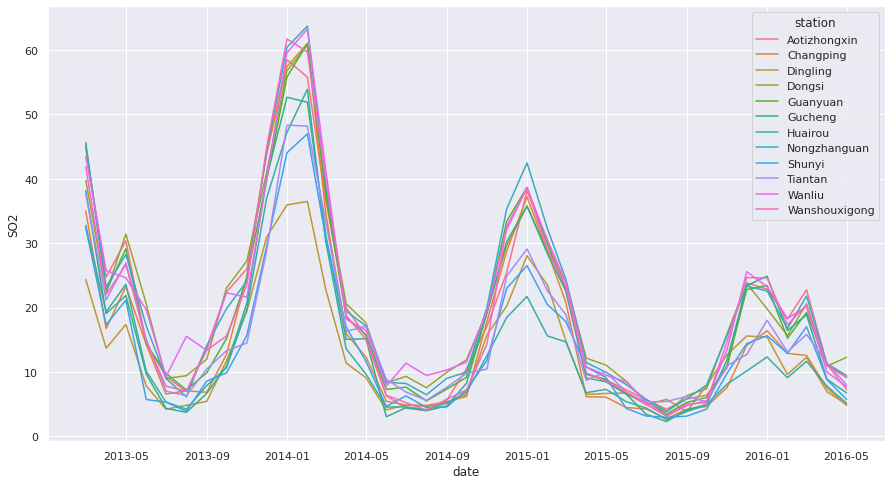

In [24]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="SO2",hue="station", data=trend)

<AxesSubplot:xlabel='date', ylabel='PM10'>

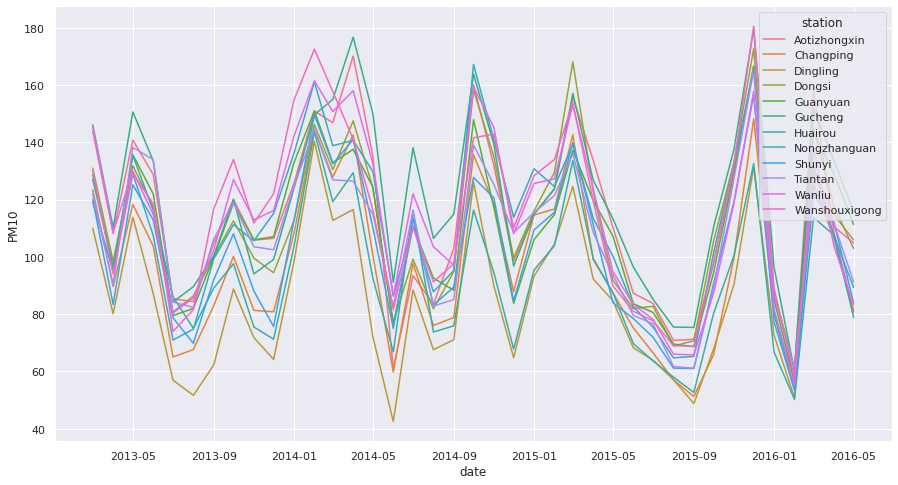

In [25]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="PM10",hue="station", data=trend)

<AxesSubplot:xlabel='date', ylabel='NO2'>

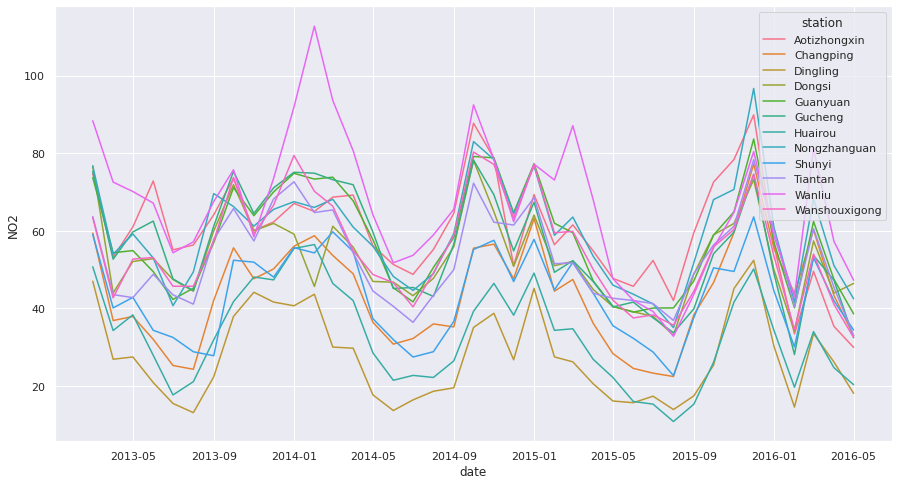

In [26]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="NO2",hue="station", data=trend)

<AxesSubplot:xlabel='date', ylabel='CO'>

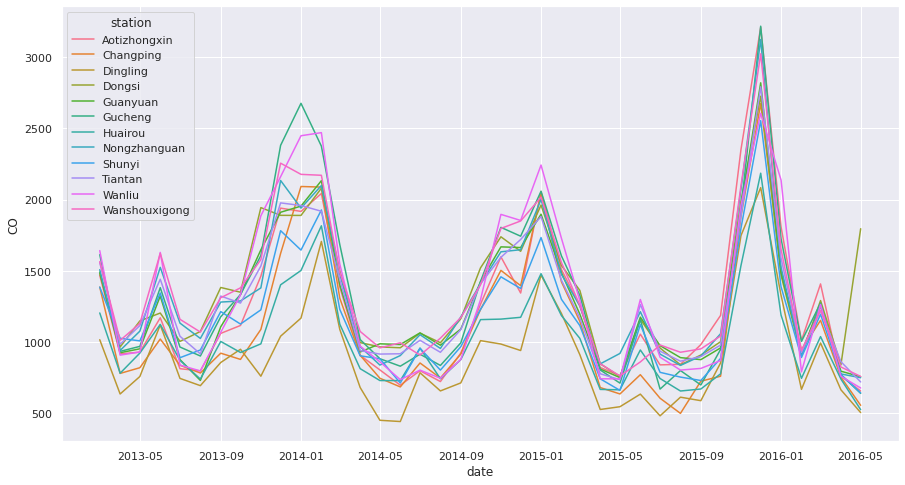

In [27]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="CO",hue="station", data=trend)

<AxesSubplot:xlabel='date', ylabel='O3'>

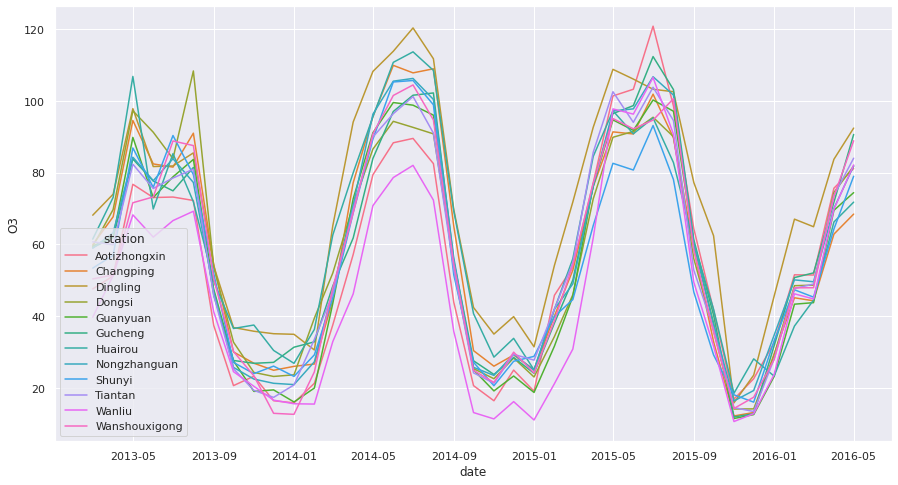

In [28]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="O3",hue="station", data=trend)

## AQI Calculation

In [29]:

# func to calculate rolling average for various components required for AQI calculation
def rolling_average(df):
    df["PM10_24hr_avg"] = df.groupby("station")["PM10"].rolling(window = 24, min_periods = 16).mean().values
    df["PM2.5_24hr_avg"] = df.groupby("station")["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
    df["SO2_24hr_avg"] = df.groupby("station")["SO2"].rolling(window = 24, min_periods = 16).mean().values
    df["NO2_24hr_avg"] = df.groupby("station")["NO2"].rolling(window = 24, min_periods = 16).mean().values
    df["CO_8hr_max"] = df.groupby("station")["CO"].rolling(window = 8, min_periods = 1).max().values
    df["O3_8hr_max"] = df.groupby("station")["O3"].rolling(window = 8, min_periods = 1).max().values

def compute_aqi(df):
    
    rolling_average(df)

    df["Checks"] = (df["PM2.5_24hr_avg"] > 0).astype(int) + \
                (df["PM10_24hr_avg"] > 0).astype(int) + \
                (df["SO2_24hr_avg"] > 0).astype(int) + \
                (df["NO2_24hr_avg"] > 0).astype(int) + \
                (df["CO_8hr_max"] > 0).astype(int) + \
                (df["O3_8hr_max"] > 0).astype(int)

    
    
    df["AQI_calculated"] = round(df[["PM2.5_24hr_avg", "PM10_24hr_avg", "SO2_24hr_avg", "NO2_24hr_avg",
                                     "CO_8hr_max", "O3_8hr_max"]].max(axis = 1))
    df.loc[df["PM2.5_24hr_avg"] + df["PM10_24hr_avg"] <= 0, "AQI_calculated"] = np.NaN
    df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

    
    return df

In [30]:
train = compute_aqi(train)
train.head(3)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,source_file,date,PM10_24hr_avg,PM2.5_24hr_avg,SO2_24hr_avg,NO2_24hr_avg,CO_8hr_max,O3_8hr_max,Checks,AQI_calculated
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 00:00:00,NaN,NaN,NaN,NaN,300.0,77.0,2,NaN
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 01:00:00,NaN,NaN,NaN,NaN,300.0,77.0,2,NaN
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 02:00:00,NaN,NaN,NaN,NaN,300.0,77.0,2,NaN


<AxesSubplot:ylabel='station'>

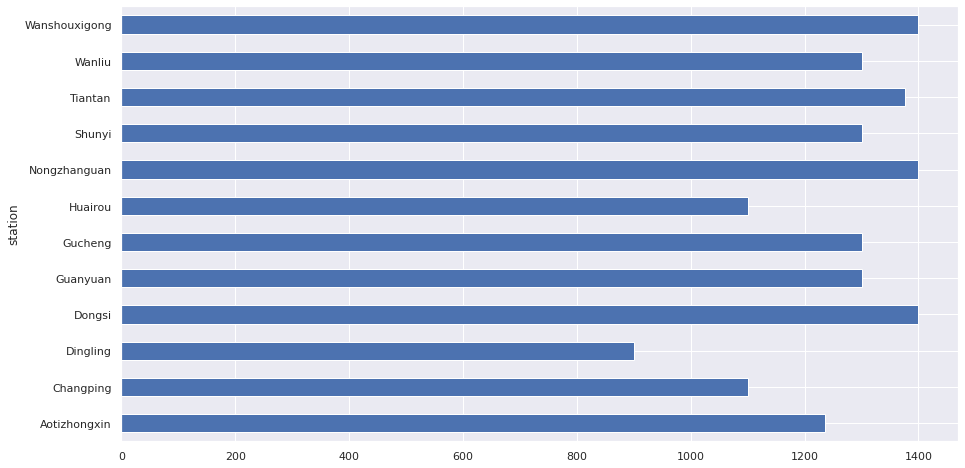

In [31]:
plt.figure(figsize=(15,8))
train.groupby(['station'])['AQI_calculated'].median().plot(kind='barh')

## Data Transformation for ML Model Training

In [25]:
cat_features = ['month','wd','WSPM','station']
num_features = ['day','hour','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN',]

enc = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

cat_tranform = enc.fit_transform(train[cat_features].astype(str))
num_transform = scaler.fit_transform(train[num_features])

num_df =  pd.DataFrame(num_transform,columns=num_features)
cat_df = pd.DataFrame(cat_tranform.todense(),columns=enc.get_feature_names())

x_train = pd.concat([num_df,cat_df],axis=1,ignore_index=False,sort=False)
x_train.head(3)

,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,x0_1,x0_10,x0_11,x0_12,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x1_E,x1_ENE,x1_ESE,x1_N,x1_NE,x1_NNE,x1_NNW,x1_NW,x1_S,x1_SE,x1_SSE,x1_SSW,x1_SW,x1_W,x1_WNW,x1_WSW,x1_['E' 'ENE'],x1_['E' 'N' 'WNW'],x1_['E' 'N'],x1_['E' 'NE'],x1_['ENE' 'NE' 'S' 'SE' 'SW'],x1_['ENE' 'NNE' 'SSE'],x1_['ENE' 'NNE'],x1_['ENE' 'NW'],x1_['ENE' 'WSW'],x1_['ESE' 'N' 'NNE' 'SSE'],x1_['ESE' 'NE'],...,x2_6.2,x2_6.3,x2_6.4,x2_6.5,x2_6.6,x2_6.7,x2_6.8,x2_6.9,x2_7.0,x2_7.1,x2_7.2,x2_7.3,x2_7.4,x2_7.5,x2_7.6,x2_7.7,x2_7.8,x2_7.9,x2_8.0,x2_8.1,x2_8.2,x2_8.3,x2_8.4,x2_8.5,x2_8.6,x2_8.7,x2_8.8,x2_8.9,x2_9.0,x2_9.1,x2_9.2,x2_9.3,x2_9.4,x2_9.5,x2_9.6,x2_9.7,x2_9.8,x2_9.9,x3_Aotizhongxin,x3_Changping,x3_Dingling,x3_Dongsi,x3_Guanyuan,x3_Gucheng,x3_Huairou,x3_Nongzhanguan,x3_Shunyi,x3_Tiantan,x3_Wanliu,x3_Wanshouxigong
0,-1.663384,-1.656765,-0.968481,-0.543513,0.149633,-0.383834,0.553957,-1.183088,1.016241,-1.506042,-0.07488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.663384,-1.512527,-1.001278,-0.543513,0.149633,-0.383834,0.553957,-1.218743,1.054946,-1.535245,-0.07488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.663384,-1.368288,-0.968481,0.168355,0.149633,-0.473820,-0.093530,-1.254397,1.054946,-1.593651,-0.07488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y_train = train['PM2.5']
y_train.head(3)

0    6.0
1    6.0
2    5.0
Name: PM2.5, dtype: float64

In [27]:
cat_tranform = enc.transform(test[cat_features].astype(str))
num_transform = scaler.transform(test[num_features])

num_df =  pd.DataFrame(num_transform,columns=num_features)
cat_df = pd.DataFrame(cat_tranform.todense(),columns=enc.get_feature_names())

x_test = pd.concat([num_df,cat_df],axis=1,ignore_index=False,sort=False)
x_test.head(3)

,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,x0_1,x0_10,x0_11,x0_12,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x1_E,x1_ENE,x1_ESE,x1_N,x1_NE,x1_NNE,x1_NNW,x1_NW,x1_S,x1_SE,x1_SSE,x1_SSW,x1_SW,x1_W,x1_WNW,x1_WSW,x1_['E' 'ENE'],x1_['E' 'N' 'WNW'],x1_['E' 'N'],x1_['E' 'NE'],x1_['ENE' 'NE' 'S' 'SE' 'SW'],x1_['ENE' 'NNE' 'SSE'],x1_['ENE' 'NNE'],x1_['ENE' 'NW'],x1_['ENE' 'WSW'],x1_['ESE' 'N' 'NNE' 'SSE'],x1_['ESE' 'NE'],...,x2_6.2,x2_6.3,x2_6.4,x2_6.5,x2_6.6,x2_6.7,x2_6.8,x2_6.9,x2_7.0,x2_7.1,x2_7.2,x2_7.3,x2_7.4,x2_7.5,x2_7.6,x2_7.7,x2_7.8,x2_7.9,x2_8.0,x2_8.1,x2_8.2,x2_8.3,x2_8.4,x2_8.5,x2_8.6,x2_8.7,x2_8.8,x2_8.9,x2_9.0,x2_9.1,x2_9.2,x2_9.3,x2_9.4,x2_9.5,x2_9.6,x2_9.7,x2_9.8,x2_9.9,x3_Aotizhongxin,x3_Changping,x3_Dingling,x3_Dongsi,x3_Guanyuan,x3_Gucheng,x3_Huairou,x3_Nongzhanguan,x3_Shunyi,x3_Tiantan,x3_Wanliu,x3_Wanshouxigong
0,-0.30084,-0.791336,-1.012210,-0.674069,0.002158,-0.563807,-0.669074,-0.443258,0.358256,0.187718,-0.07488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.30084,-0.647097,-0.487451,-0.674069,-0.227751,-0.653793,-0.507202,0.002423,0.425990,0.085508,-0.07488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.30084,-0.502859,-0.268801,-0.674069,0.174590,-0.563807,-0.723031,0.180695,0.445343,0.063606,-0.07488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
y_test = test['PM2.5']

## Creating A Simple Predictive


In [3]:
# predict the PM2.5 concentration in a given hour based on the weather 
dataset = pd.DataFrame(pd.read_csv(path, index_col = 0))
dataset['DateTime'] = pd.to_datetime(dataset[['year', 'month','day', 'hour']])
# Drop the rows with missing values
dataset = dataset.drop(['year', 'month','day', 'hour'], axis = 1)
# Impute the values in reference to other values in the same column
dataset = dataset[['DateTime', 'DEWP', 'TEMP', 'PRES','wd', 'WSPM', 'PM2.5']].iloc[24:].reset_index().drop('No', axis = 1)
dataset[['PM2.5']] = dataset[['PM2.5']].interpolate(method='linear')
dataset.dropna(inplace=True)
dataset.head()

,DateTime,DEWP,TEMP,PRES,wd,WSPM,PM2.5
0,2013-03-02 00:00:00,-17.6,-0.4,1031.0,ENE,1.4,22.0
1,2013-03-02 01:00:00,-17.3,-1.0,1031.3,NNE,1.1,14.0
2,2013-03-02 02:00:00,-16.9,-1.5,1030.9,E,1.7,13.0
3,2013-03-02 03:00:00,-17.6,-1.4,1030.6,NNE,1.4,3.0
4,2013-03-02 04:00:00,-17.7,-1.5,1030.8,NNW,0.9,3.0


In [4]:
dataset = dataset.set_index('DateTime')
X_train, X_test, y_train, y_test = train_test_split(dataset[['DEWP', 'TEMP', 'PRES', 'WSPM']], dataset[['PM2.5']], test_size=0.2)\

model = sm.OLS(np.asarray(y_train), np.asarray(X_train))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.587
Model:                            OLS   Adj. R-squared (uncentered):              0.587
Method:                 Least Squares   F-statistic:                              9932.
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:15:17   Log-Likelihood:                     -1.6037e+05
No. Observations:               27962   AIC:                                  3.207e+05
Df Residuals:                   27958   BIC:                                  3.208e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


My goal is to build a model to predict the PM2.5 concentration in a given hour based on the weather factors in the dataset: dew point, temperature, pressure, combined wind direction, wind speed, cumulated hours of snow, and cumulated hours of rain. The simplest approach is to use these features as-is, without any modification. Since most of the data is numerical, the simplest statistical model to apply is an ordinary Least Squares Regression model. To do so, we first break up the dataset into a test and training set. We will build the model with the training set, and evaluate its performance with the test set. This ensures the model is as unbiased as possible. To do so:

In [13]:
y_pred = results.predict(np.asarray(X_test))
mse = mean_squared_error(np.asarray(y_test), y_pred)
rmse = mse**0.5
print(f'RMSE: {rmse}')
print(f'Baseline Model (avg.): {dataset['PM2.5'].mean()}')
# The predictions given by the model are roughly 75 ug/m3 off ( microgram / cubic meter) , on average. Given that the average value of PM2.5 is 83 ug/m3 ( microgram / cubic meter) , this model clearly isn’t performing well. Fortunately, we can do some feature engineering and then test out some other models.

34.19040506453418


In [23]:
# Feature Engineering
dataset = dataset.reset_index() 
six_df = pd.DataFrame() # six-hour lagged PM2.5 concentration
twelve_df = pd.DataFrame() # twelve-hour lagged PM2.5 concentration
tf_df = pd.DataFrame()
for i in range(len(dataset)):
    six_df = pd.concat([six_df,pd.DataFrame({'6hr_avg':[sum(dataset['PM2.5'].iloc[i:i+6])/6]}, index = [i+6])])
    twelve_df = pd.concat([twelve_df,pd.DataFrame({'12hr_avg':[sum(dataset['PM2.5'].iloc[i:i+12])/12]}, index = [i+12])])
    tf_df = pd.concat([tf_df,pd.DataFrame({'24hr_avg':[sum(dataset['PM2.5'].iloc[i:i+24])/24]}, index = [i+24])])
   
dataset = pd.merge(dataset, six_df, left_index=True, right_index=True)
dataset = pd.merge(dataset, twelve_df, left_index=True, right_index=True)
dataset = pd.merge(dataset, tf_df, left_index=True, right_index=True)

dataset = pd.merge(dataset,pd.get_dummies(dataset['wd']), left_index=True, right_index=True)

## Fit Linear Model

In [29]:
model_1 = LinearRegression().fit(x_train, y_train)
y_test_pred = model_1.predict(x_test)
print(f"RMSE on test {np.sqrt(mean_squared_error(y_test,y_test_pred))}")

RMSE on test 9890295.143676398


## Random Forest Model 

In [30]:
model_2 = RandomForestRegressor(max_depth=10, random_state=0)
model_2.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [31]:
y_test_pred_2 = model_2.predict(x_test)
print(f"RMSE on test {np.sqrt(mean_squared_error(y_test,y_test_pred_2))}")

RMSE on test 21.512709377998224


In [ ]:
## Test Data Prediction
test = compute_aqi(test)
test.rename({'PM2.5':"Actual PM2.5","AQI_calculated":"Actual AQI"},axis=1,inplace=True)

test['PM2.5'] = y_test_pred_2
test = compute_aqi(test)
test.rename({'PM2.5':"Predicted PM2.5","AQI_calculated":"Predicted AQI"},axis=1,inplace=True)
test[['date', 'station','Actual PM2.5','Predicted PM2.5','Actual AQI','Predicted AQI']].to_csv("Test_Prediction.csv",index=False)
test[['Actual PM2.5','Predicted PM2.5']].sample(10)

## Using XGBoost For Predictive Modeling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset[['DEWP', 'TEMP', 'PRES', 'WSPM','6hr_avg', '12hr_avg', '24hr_avg','NE','NW','SE']], dataset[['PM2.5']], test_size=0.2)

model = sm.OLS(np.asarray(y_train), np.asarray(X_train))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                          2.919e+04
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:27:37   Log-Likelihood:                     -1.3852e+05
No. Observations:               27943   AIC:                                  2.771e+05
Df Residuals:                   27933   BIC:                                  2.772e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
# The R-squared value is already much better at 0.920. This time we also obtain a much better RMSE:
y_pred = results.predict(np.asarray(X_test))

mse = mean_squared_error(np.asarray(y_test), y_pred)
rmse = mse**0.5
print(rmse)
# The effect of our attempt at feature engineering is quite drastic since it cut our RMSE in half. We can also implement models other than Ordinary Least Squares (OLS) model. In fact, the statsmodels package has a host of other regression models we can try. 

34.19040506453418


In [10]:
# To apply the xgboost algorithm in Python:
import xgboost as xgb

dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)
dtrain = xgb.DMatrix(X_train, y_train,feature_names=X_train.columns)

param = {'verbosity':1,
        'objective':'reg:squarederror',
        'booster':'gblinear',
        'eval_metric' :'rmse',
        'learning_rate': 1}

evallist = [(dtrain, 'train')]

In [11]:
num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist)
# Using the xgboost algorithm, we obtain a slightly better RMSE (~38.6 compared to ~39.5). Feel free to try different learning rates or number of iterations to see how the result changes.

[0]	train-rmse:94.12472
[1]	train-rmse:63.37987
[2]	train-rmse:60.70526
[3]	train-rmse:56.73326
[4]	train-rmse:51.95778
[5]	train-rmse:47.69884
[6]	train-rmse:44.36823
[7]	train-rmse:41.95024
[8]	train-rmse:40.23331
[9]	train-rmse:39.02640
[10]	train-rmse:38.16262
[11]	train-rmse:37.41772
[12]	train-rmse:37.14246
[13]	train-rmse:36.63374
[14]	train-rmse:36.30633
[15]	train-rmse:36.03289
[16]	train-rmse:35.80900
[17]	train-rmse:35.61784
[18]	train-rmse:35.45325
[19]	train-rmse:35.34917
[20]	train-rmse:35.20448
[21]	train-rmse:35.09908
[22]	train-rmse:35.01352
[23]	train-rmse:34.93498
[24]	train-rmse:34.86489
[25]	train-rmse:34.80344
[26]	train-rmse:34.75013
[27]	train-rmse:34.70371
[28]	train-rmse:34.65871
[29]	train-rmse:34.62499
[30]	train-rmse:34.59489
[31]	train-rmse:34.57280
[32]	train-rmse:34.54781
[33]	train-rmse:34.52821
[34]	train-rmse:34.51197
[35]	train-rmse:34.49719
[36]	train-rmse:34.48549
[37]	train-rmse:34.47533
[38]	train-rmse:34.46658
[39]	train-rmse:34.45904
[40]	train

# Part III High Complex LSTM Model

### Data Cleaning and Pre Processing

In [19]:
wanted_col = ['PM2.5','PM10','SO2','NO2','CO','O3']

dtrain_dir = 'dataset/daily/train'
dtest_dir = 'dataset/daily/test'
mtrain_dir = 'dataset/monthly/train'
mtest_dir = 'dataset/monthly/test'


def load_dataset():

    df = pd.read_csv(path)
    print(df.head())

    return df


def datetime_index_column(df):

    df['Date-Time'] = pd.date_range(start = '2013-03-01 00:00:00',
        end = '2017-02-28 23:00:00',freq ='H')
    df.set_index('Date-Time', drop = True, inplace = True)

    return df


def data_frames(cleaned_df):

    df_PM25 = cleaned_df[['PM2.5']]
    df_PM10 = cleaned_df[['PM10']]
    df_SO2 = cleaned_df[['SO2']]
    df_NO2 = cleaned_df[['NO2']]
    df_CO = cleaned_df[['CO']]
    df_O3 = cleaned_df[['O3']]

    return [df_PM25, df_PM10, df_SO2, df_NO2, df_CO, df_O3]


def resample_data(dfs, freq = 'D'):

    if freq == 'D':
        return [each_df.resample(freq).mean() for each_df in dfs] 
    else:
        return [each_df.resample('D').max().resample(freq).mean() for each_df in dfs]


def train_test_split(dfs, train_end_index = '2016-02-29', test_start_index = '2016-03-01', freq = 'D'):

    if freq == 'M':
        test_start_index = '2016-03'
        train_end_index = '2016-02'
        
    return [(each_df[:train_end_index], each_df[test_start_index:]) for each_df in dfs]


def create_dataset_directories():
    os.mkdir('dataset/daily')
    os.mkdir('dataset/monthly')


def save_train_test_data(train_test_list, train_dir, test_dir):

    for each_train_test in train_test_list:
        filename = each_train_test[0].columns.values[0]
        (each_train_test[0].reset_index()).to_csv(os.path.join(train_dir, 'train_'+filename+'.csv'), index = False)
        (each_train_test[1].reset_index()).to_csv(os.path.join(test_dir, 'test_'+filename+'.csv'), index = False)

        


df = load_dataset()
df = datetime_index_column(df)
df = df[wanted_col]
cleaned_df = df.interpolate()
del df
df_list = data_frames(cleaned_df)

df_PM25, df_PM10, df_SO2, df_NO2, df_CO, df_O3 = resample_data(df_list)
dfm_PM25, dfm_PM10, dfm_SO2, dfm_NO2, dfm_CO, dfm_O3 = resample_data(df_list, freq = 'MS')

df_list = [df_PM25, df_PM10, df_SO2, df_NO2, df_CO, df_O3]
dfm_list = [dfm_PM25, dfm_PM10, dfm_SO2, dfm_NO2, dfm_CO, dfm_O3]

dtrain_test_list = train_test_split(df_list)
mtrain_test_list = train_test_split(dfm_list)

save_train_test_data(dtrain_test_list, dtrain_dir, dtest_dir)
save_train_test_data(mtrain_test_list, mtrain_dir, mtest_dir)

   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  


### Model Training

In [22]:
def fit_LSTM(scaled_train_data, time_steps, n_features, batch_size = 6, activation = 'relu', epochs = 10):

    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)
    model = Sequential()
    model.add(LSTM(units = 200, activation = activation, input_shape = (time_steps, n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(6))
    model.compile(optimizer='adam', loss='mse')
    model.fit_generator(generator, epochs = epochs)
    
    return model

def transform_data(train_data):

    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 


def predict_LSTM(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, lstm_model):

    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)

    for i in range(time_steps):
        pred_list.append(lstm_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    
    return df_predict

def LSTM_evaluate(train_data, test_data, df_predict ):
    
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    print('\nPredictions of ',train_data.columns.values[0])
    plt.show()
    return


Epoch 1/10
 44/122 [=========>....................] - ETA: 25s - loss: 0.0325

KeyboardInterrupt: 

### LSTM Univariate Time Series Forecasting Model

In [ ]:
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

scaled_train_PM25, scaler = transform_data(train_PM25)

time_steps = 365
n_feature = 1
model = fit_LSTM(scaled_train_PM25, time_steps, n_feature)

predictions = predict_LSTM(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)

### LSTM Multivariate Time Series Forecasting Model

In [ ]:
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('dataset/daily/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('dataset/daily/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('dataset/daily/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('dataset/daily/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('dataset/daily/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('dataset/daily/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('dataset/daily/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('dataset/daily/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('dataset/daily/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('dataset/daily/test/test_O3.csv', parse_dates = [0], index_col = [0])

list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]

scaled_train_PM25, scaler = transform_data(train_PM25)
scaled_train_PM10, scaler = transform_data(train_PM10)
scaled_train_SO2, scaler = transform_data(train_SO2)
scaled_train_NO2, scaler = transform_data(train_NO2)
scaled_train_CO, scaler = transform_data(train_CO)
scaled_train_PM10, scaler = transform_data(train_PM10)
scaled_train_O3, scaler = transform_data(train_O3)


list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2,
 scaled_train_CO, scaled_train_O3]

all_attributes = []
joined_element = []

for i in range(0, len(scaled_train_O3)):
    for j in range(0, len(list_scaled_train)):
        joined_element = np.append(joined_element, list_scaled_train[j][i])
    all_attributes.append(joined_element)
    joined_element = []

time_steps = 365
n_feature = 6
model = fit_LSTM(np.array(all_attributes), time_steps, n_feature)

model.save('trained_model.h5', model)
LSTM_evaluate(train_data, test_data, df_predict )
# model = tf.keras.models.load_model('trained_model.h5')